In [1]:
import numpy as np
import math
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *
import scipy.io as sio
from scipy import signal
import numpy.linalg

# Revisit 092219 Twisted TW2 data
Previous attempt using cross-correlation for peak detection, generate binary matrix, then perform PCA didn't work out well.
<br>Ideas to improve data processing:
<br>1. Generate a mask from HAADF image to filter out all the thick parts, so that the complicated diffraction pattern from thick part won't confuse PCA.
<br>2. Use Hough transform to detect circles instead of simple cross-correlation, which seems to be more effective on the averaged image.

## Build mask to cover thin region based on HAADF intensity

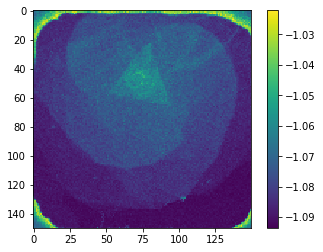

In [3]:
import csv

file_HAADF = [image for image in os.listdir('/srv/home/chenyu/DEbackup/092219/S2/') if '_Preview' in image]
file_HAADF = file_HAADF[0]
with open('/srv/home/chenyu/DEbackup/092219/S2/' +  file_HAADF) as csvfile:
    file=csv.reader(open('/srv/home/chenyu/DEbackup/092219/S2/'+file_HAADF,'r'))
    n=[]
    for row in file:
        n.append(row)

HAADFarray = np.transpose(np.asarray(n))
HAADFarray = np.squeeze(HAADFarray)
HAADFarray = HAADFarray.astype(np.float)
HAADFarray = np.reshape(HAADFarray,(150,150))
plt.imshow(HAADFarray)
plt.colorbar()

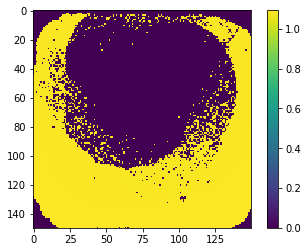

In [521]:
# Define work area by set a threshold on HAADF image
mask = -HAADFarray
mask[mask<1.080] = 0
plt.imshow(mask)
plt.colorbar()

## Register all frames within the mask

In [17]:
# Generate PACBED according to masked region
# Register all frame after downsampling to 300x300 per frame
rx = 150
ry = 150
refpath = '/srv/home/chenyu/DEbackup/092219/S0_10kX/npy/'
path = '/srv/home/chenyu/DEbackup/092219/S2/npy/'
PACBED = np.zeros((300,300))
dataset = np.zeros((150,150,300,300))
dataset_ref = np.zeros((150,150,300,300))

# load reference frame, use center frame as reference
irow = 75
icol = 75
nSample = irow * rx + icol + 1;
Sample_ref = np.load(refpath+'S0_'+format(nSample,'05')+'.npy')
Sample_ref = cv2.resize(Sample_ref, (300,300), interpolation = cv2.INTER_AREA)
num_rows, num_cols = Sample_ref.shape[:2]

# loop over all beam positions in the ROI
for irow in range(150):
    if irow%10 == 0:
        print('Now working on row '+str(irow))
    for icol in range(150):
        # only do registration if this pixel is masked
        if mask[irow, icol] != 0:
            nSample = irow * rx + icol + 1;
            Sample = np.load(refpath+'S0_'+format(nSample,'05')+'.npy')
            Sample = cv2.resize(Sample, (300,300), interpolation = cv2.INTER_AREA)
            
            corr = np.fft.fftshift(np.fft.ifft2(np.conjugate(np.fft.fft2(Sample))*np.fft.fft2(Sample_ref))).real
            y, x = np.unravel_index(np.argmax(corr), corr.shape)
            x = x - 150
            y = y - 150
            translation_matrix = np.float32([[1,0,x],[0,1,y]])
            # Also keep all the blank scan frames inside a datacube so that one can check whether the registration is correct
            dataset_ref[irow,icol,:,:] = cv2.warpAffine(Sample, translation_matrix, (num_cols, num_rows))

            # load CBED with sample and correct for the shift
            Sample = np.load(path + 'S2_'+format(nSample,'05')+'.npy')
            Sample = cv2.resize(Sample, (300,300), interpolation = cv2.INTER_AREA)
            dataset[irow,icol,:,:] = cv2.warpAffine(Sample, translation_matrix, (num_cols, num_rows))
            
            # use masked region to genrate registered PACBED
            PACBED = PACBED + dataset[irow,icol,:,:]

Now working on row 0
Now working on row 10
Now working on row 20
Now working on row 30
Now working on row 40
Now working on row 50
Now working on row 60
Now working on row 70
Now working on row 80
Now working on row 90
Now working on row 100
Now working on row 110
Now working on row 120
Now working on row 130
Now working on row 140


Text(0.5, 1.0, 'Registered PACBED from thin region')

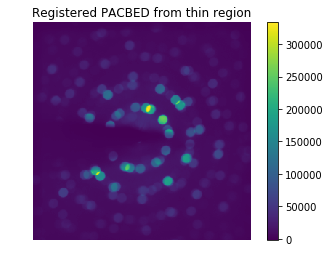

In [22]:
np.save('/srv/home/chenyu/DEbackup/092219/S2/Thin_registered.npy',dataset)
np.save('/srv/home/chenyu/DEbackup/092219/S2/Thin_ref_registered.npy',dataset_ref)
plt.imshow(PACBED)
plt.colorbar()
plt.axis('off')
plt.title('Registered PACBED from thin region')

## Detect all peaks from PACBED using Hough transform based circle detection

In [590]:
# Apply Hough transform to detect disks from PACBED
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, disk
from skimage.feature import canny
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

dataset = np.load('/srv/home/chenyu/DEbackup/092219/S2/Thin_registered.npy')
PACBED = np.sum(np.sum(dataset[:,100:150],axis=0),axis=0)

(-0.5, 299.5, 299.5, -0.5)

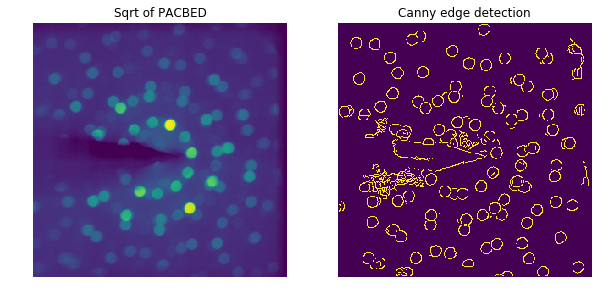

In [619]:
# Canny edge detection
fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
# selem = disk(4)
temp = PACBED
temp[temp<0]=0
plt.imshow(np.sqrt(temp))
plt.title('Sqrt of PACBED')
plt.axis('off')
# plt.colorbar()

fig.add_subplot(122)
temp = PACBED
plt.imshow(canny(np.sqrt(temp),sigma=0,low_threshold=0,high_threshold=70))
plt.title('Canny edge detection')
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


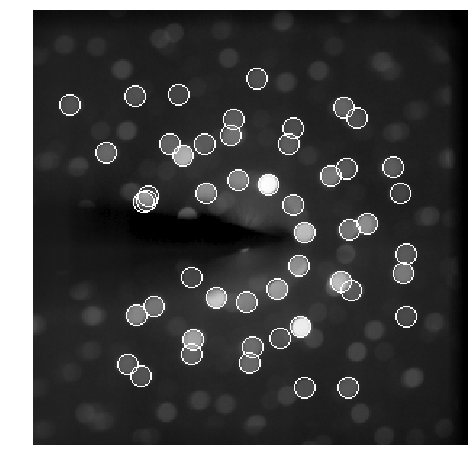

In [620]:
# Test Hough Transform to find circles
edges = canny(np.sqrt(temp),sigma=0,low_threshold=50,high_threshold=170)

# Detect two radii
hough_radii = np.arange(7,8,1)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii)

# print(cx,cy,radii)
# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,8))
PACBED_norm = PACBED / np.amax(PACBED)
PACBED_norm[PACBED_norm<0] = 0
PACBED_norm = np.sqrt(PACBED_norm)
image = color.gray2rgb(PACBED_norm)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

cx_all = cx
cy_all = cy

## Detect circles on a single frame using Hough detection

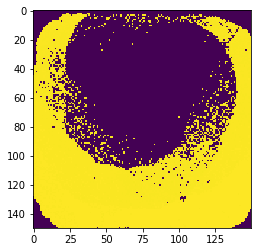

In [531]:
plt.imshow(mask)
# plt.axis('off')

In [621]:
# Loop over all the beam positions on mask to detect disks
nSample = 0
input_mat = np.zeros((len(cx_all),np.count_nonzero(mask)))

for irow in range(150):
    if irow%10 == 0:
        print('Now working on row '+str(irow))
    for icol in range(100,150):
        # only do registration if this pixel is masked
        if mask[irow, icol] != 0:
            temp = dataset[irow,icol,:,:]
            cx, cy = DiskDetection(temp)
            if cx.any():
                for i in range(len(cx_all)):
                    dist = np.sqrt(np.square(cx-cx_all[i]) + np.square(cy-cy_all[i]))
                    if np.amin(dist) < 5:
                        input_mat[i,nSample] = 1
            nSample = nSample + 1
            
input_mat = input_mat[:,0:nSample+1]

Now working on row 0
Now working on row 10
Now working on row 20
Now working on row 30
Now working on row 40
Now working on row 50
Now working on row 60
Now working on row 70
Now working on row 80
Now working on row 90
Now working on row 100
Now working on row 110
Now working on row 120
Now working on row 130
Now working on row 140


In [437]:
np.save('/srv/home/chenyu/DEbackup/092219/S2/ThinRegion_allPeaks_binary.npy',input_mat)

## Test PCA on binary matrix

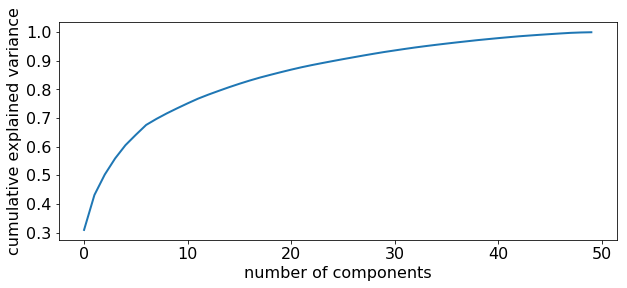

In [622]:
# Draw scree plot
from sklearn.decomposition import PCA
pca = PCA().fit(np.transpose(input_mat))
fig = plt.figure(figsize=(10,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_),linewidth=2)
plt.xlabel('number of components',fontsize=16)
plt.ylabel('cumulative explained variance',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [623]:
pca = PCA(10)
pca.fit(np.transpose(input_mat))
print(pca.components_.shape) # pca_components contains the new feature matrix
score_mat = pca.transform(np.transpose(input_mat)) # score_mat is the loading matrix
print(score_mat.shape)

(10, 50)
(4415, 10)


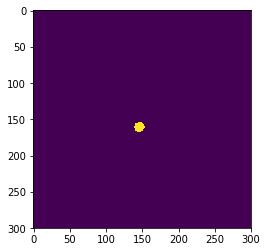

In [535]:
dataset_ref = np.load('/srv/home/chenyu/DEbackup/092219/S2/Thin_ref_registered.npy')
mask_disk = np.sum(np.sum(dataset_ref,axis=0),axis=0)
mask_disk = np.heaviside(mask_disk - 50000,1)
plt.imshow(mask_disk)

Now working on row 0
Now working on row 10
Now working on row 20
Now working on row 30
Now working on row 40
Now working on row 50
Now working on row 60
Now working on row 70
Now working on row 80
Now working on row 90
Now working on row 100
Now working on row 110
Now working on row 120
Now working on row 130
Now working on row 140


Text(0.5, 1.0, 'Loading map')

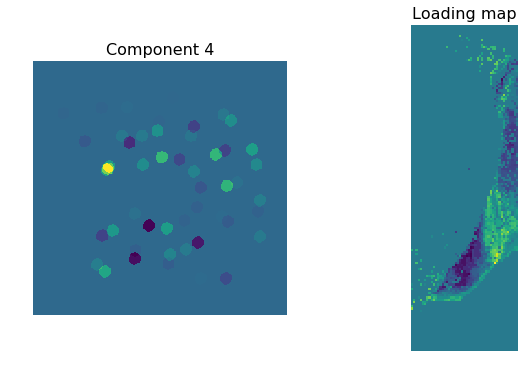

In [628]:
# visulize pca component together with loading map
icomponent = 4
component_map = np.zeros((300,300))
for i in range(len(pca.components_[icomponent,:])):
    x = cx_all[i]
    y = cy_all[i]
    component_map[x,y] = pca.components_[icomponent,i]
    
# visulize pca components
fig = plt.figure(figsize=(10,6))
fig.add_subplot(121)
corr = (np.fft.fftshift(np.fft.ifft2(np.fft.fft2(mask_disk)*np.fft.fft2(component_map)))).real
plt.imshow(np.transpose(corr))
# plt.colorbar()
plt.axis('off')
plt.title('Component '+str(icomponent),fontsize=16)

temp = score_mat[:,icomponent]
loading = np.zeros((150,150))
nSample = 0
# for irow in range(150):
# #     if irow%10 == 0:
# #         print('Now working on row '+str(irow))
#     for icol in range(150):
#         if mask[irow, icol] != 0:
#             loading[irow,icol] = score_mat[nSample,icomponent]
#             nSample = nSample + 1
            
for irow in range(150):
    if irow%10 == 0:
        print('Now working on row '+str(irow))
    for icol in range(100,150):
        if mask[irow, icol] != 0:
            loading[irow,icol] = score_mat[nSample,icomponent]
            nSample = nSample + 1
            
            
# visulize loading map
fig.add_subplot(122)
plt.imshow(loading[:,100:-1])
# plt.colorbar()
plt.axis('off')
plt.title('Loading map',fontsize=16)

# # plot simple DF image
# fig.add_subplot(133)
# plt.imshow(DF)
# plt.axis('off')

## Test k-means clustering (or any other clustering method)

In [653]:
input_mat.shape
from sklearn.cluster import KMeans
ncluster=3
kmeans = KMeans(n_clusters=ncluster, random_state=0)
clusters = kmeans.fit_predict(np.transpose(input_mat))
kmeans.cluster_centers_.shape

(3, 50)

In [654]:
ncluster

3

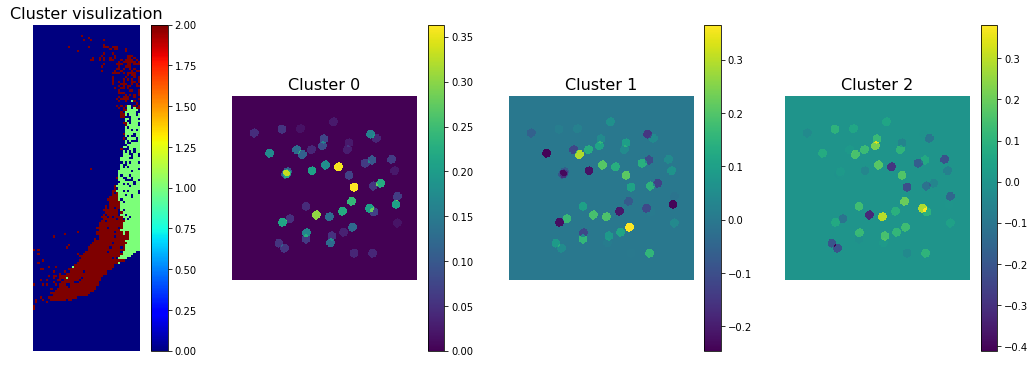

In [655]:
loading = np.zeros((150,150))
nSample = 0

for irow in range(150):
#     if irow%10 == 0:
#         print('Now working on row '+str(irow))
    for icol in range(100,150):
        if mask[irow, icol] != 0:
            loading[irow,icol] = clusters[nSample]
            nSample = nSample + 1
    
# visulize pca components
fig = plt.figure(figsize=(19,6))
fig.add_subplot(1,ncluster+1,1)
plt.imshow(loading[:,100:-1],cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title('Cluster visulization',fontsize=16)

for icluster in range(ncluster):
    icomponent = icluster
    component_map = np.zeros((300,300))
    for i in range(len(kmeans.cluster_centers_[icomponent,:])):
        x = cx_all[i]
        y = cy_all[i]
        component_map[x,y] = pca.components_[icomponent,i]

    fig.add_subplot(1,ncluster+1,icluster+2)
    corr = (np.fft.fftshift(np.fft.ifft2(np.fft.fft2(mask_disk)*np.fft.fft2(component_map)))).real
    plt.imshow(np.transpose(corr))
    plt.colorbar()
    plt.axis('off')
    plt.title('Cluster '+str(icomponent),fontsize=16)


### Function to run disk detection on single frame and debug script for disk detection

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49


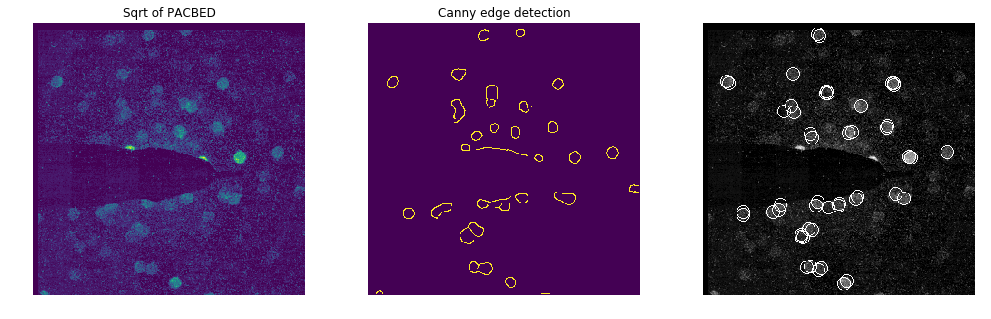

In [466]:
# Test circle detection on single frame
temp = dataset[110,55,:,:]
temp[temp<0] = 0

# Test Hough Transform to find circles
edges = canny(temp,sigma=3,low_threshold=0,high_threshold=10)

# Detect two radii
hough_radii = np.arange(7,8,1)
hough_res = hough_circle(edges, hough_radii)

# Detect all the circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii)

# Draw them
temp_norm = temp / np.amax(temp)
temp_norm[temp_norm<0] = 0
temp_norm = np.sqrt(temp_norm)
image = color.gray2rgb(temp_norm)
for center_y, center_x, radius in zip(cy, cx, radii):
#     print(center_y,center_x,radius)
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (220, 20, 20)

print(cx.shape[0])

fig = plt.figure(figsize=(17,5))

fig.add_subplot(131)
plt.imshow(np.sqrt(temp))
plt.title('Sqrt of PACBED')
plt.axis('off')
# plt.colorbar()

fig.add_subplot(132)
plt.imshow(canny(temp,sigma=3,low_threshold=0,high_threshold=10))
plt.title('Canny edge detection')
plt.axis('off')

fig.add_subplot(133)
plt.imshow(image, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 299.5, 299.5, -0.5)

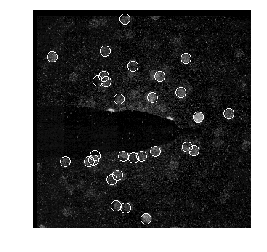

In [469]:
from scipy.spatial import distance
peaks_list = [cx,cy]
peaks_list = np.asarray(peaks_list)
peaks_list = np.transpose(peaks_list)

if len(peaks_list) > 1:
    for i in range(len(peaks_list)):
        peak = np.expand_dims(array([cx[i],cy[i]]),axis=1)
        peak = np.transpose(peak)
        dist_list = distance.cdist(peak,peaks_list)
        dist_min = np.min(dist_list[np.nonzero(dist_list)])

        if dist_min < 5:
            index_min = np.argmin(dist_list[np.nonzero(dist_list)])
            peaks_list[i,:] = [0,0]
#             print(dist_min)

    index = (peaks_list[:,0]!=0) & (peaks_list[:,1]!=0)
    cx_new = peaks_list[index,0]
    cx_new = np.squeeze(np.transpose(cx_new))
    cy_new = peaks_list[index,1]
    cy_new = np.squeeze(np.transpose(cy_new))

else:
    cx_new = cx
    cy_new = cy
# Draw the filtered circles
temp = dataset[110,55,:,:]
temp_norm = temp / np.amax(temp)
temp_norm[temp_norm<0] = 0
temp_norm = np.sqrt(temp_norm)
image = color.gray2rgb(temp_norm)
radius = 7

for center_y, center_x in zip(cy_new, cx_new):
#     print(center_y, center_x)
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=image.shape)
    image[circy, circx] = (220, 20, 20)
    
plt.imshow(image)
plt.axis('off')

In [468]:
def DiskDetection(image):
    temp = image
    temp[temp<0] = 0

    # Test Hough Transform to find circles
    edges = canny(temp,sigma=3,low_threshold=0,high_threshold=20)

    # Detect two radii
    hough_radii = np.arange(7,8,1)
    hough_res = hough_circle(edges, hough_radii)

    # Detect all the circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii)
    peaks_list = [cx,cy]
    peaks_list = np.asarray(peaks_list)
    peaks_list = np.transpose(peaks_list)

    if len(peaks_list) > 1:
        for i in range(len(peaks_list)):
            peak = np.expand_dims(array([cx[i],cy[i]]),axis=1)
            peak = np.transpose(peak)
            dist_list = distance.cdist(peak,peaks_list)
            dist_min = np.min(dist_list[np.nonzero(dist_list)])

            if dist_min < 4:
                index_min = np.argmin(dist_list[np.nonzero(dist_list)])
                peaks_list[i,:] = [0,0]

        index = (peaks_list[:,0]!=0) & (peaks_list[:,1]!=0)
        cx_new = peaks_list[index,0]
        cx_new = np.squeeze(np.transpose(cx_new))
        cy_new = peaks_list[index,1]
        cy_new = np.squeeze(np.transpose(cy_new))

    else:
        cx_new = cx
        cy_new = cy
        
    return cx_new, cy_new